In [1]:
import sys
import os

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("")))
sys.path.append(ROOT_DIR)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Scikit-learn utils
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

# Classifiers for attack models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


2022-05-20 10:47:20.313887: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-20 10:47:20.313952: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
#import t=privachy version 
import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy


### Definition of the datasets
1. We draw data points from a distribution.
2. We split these data points into the target dataset and a shadow dataset drawn from the same distribution.
3. We also draw a dataset from a different distribution.

**NOTE**. ***I make datasets with few samples but with many features to force the target model to overfit.***


***NOTE JIM: had to make batch_size 25 so DP optimizer would run with same hyperparams

In [4]:
n_classes = 2

# (X,y): Original distribution
X, y = make_classification(n_samples=1000,
                           n_classes=n_classes, 
                           n_features=300,
                           n_informative=300,
                           n_redundant=0,
                           n_repeated=0,
                           random_state=15
                          )
# One-hot encoding of the label
y = np.eye(n_classes)[y]

# (Xt, yt) is the target dataset, owned by the TRE and drawn from the (X,y) distribution
# (Xs, ys) is a shadow dataset drawn from the (X,y) distribution
Xt, Xs, yt, ys = train_test_split(X, y, test_size=0.50, random_state=15)

# (Xd, yd) is a shadow dataset, drawn from a different distribution (different seed)
Xd, yd = make_classification(n_samples=1000,
                           n_classes=n_classes, 
                           n_features=300,
                           n_informative=300,
                           n_redundant=0,
                           n_repeated=0,
                           random_state=42
                          )
yd = np.eye(n_classes)[yd]




In [5]:
# Split into train (member) and test (non-member) datasets
# Set shuffle to False so that Xt_membership is consistent with Xt, otherwise
# we need to stack Xt_member and Xt_nonmember again to get a consistent Xt.
Xt_member, Xt_nonmember, yt_member, yt_nonmember = train_test_split(Xt, yt, test_size=0.5, shuffle=False)

# Set membership status for future tests
Xt_membership = np.vstack(
    (
        np.ones((Xt_member.shape[0], 1), np.uint8),
        np.zeros((Xt_nonmember.shape[0], 1), np.uint8)
    )
).flatten()

### Define the target model architecture

*Again, I'm using a rather big model (for the classification task) to favour overfitting.*

In [6]:
# Define target model
# Tensorflow model (MLP) (making it big to make it overfit)

input_data = Input(shape = Xt_member[0].shape)
x = Dense(128, activation='relu')(input_data)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

2022-05-20 10:47:25.152222: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-20 10:47:25.152321: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-20 10:47:25.152374: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-05-20 10:47:25.153141: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Now try the SafeKerasModel version

In [7]:
import importlib
import safemodel
from safemodel.classifiers.safekeras import Safe_KerasModel



importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel



In [8]:
optimizer=None
safeModel = Safe_KerasModel(inputs= input_data, outputs=output,name="safekeras-test")


args is a <class 'tuple'> = ()  kwargs is a <class 'dict'>= {'inputs': <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'input_1')>, 'outputs': <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_3')>, 'name': 'safekeras-test'}
inputs is in kwargs.keys
KerasTensor(type_spec=TensorSpec(shape=(None, 300), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model parameters are within recommended ranges.



In [9]:
#safeModel.__dict__


In [10]:
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, reduction=tf.losses.Reduction.NONE)


safeModel.compile(loss=loss)#optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




Changed parameter optimizer = 'DPKerasSGDOptimizer'
Unknown optimizer <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'> - Changed parameter optimizer = 'DPKerasSGDOptimizer'
DP optimizer used = False
optimizer has been changed but fit() has not been rerun.


In [11]:
theType= type(safeModel.optimizer)
print(f'optimiser is type {theType}')

dpused,reason = safeModel.check_optimizer_is_DP(safeModel.optimizer)
print(f' It is {dpused} that the model will be DP because {reason}')

optimiser is type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
 It is True that the model will be DP because optimizer does  contain key _was_dp_gradients_called so should be DP.


(250, 300)
DP-SGD with sampling rate = 10% and noise_multiplier = 0.5 iterated over 200 steps satisfies differential privacy with eps = 50.3 and delta = 1e-05.
The optimal RDP order is 1.5.
Current epsilon is 50.301726361197794
The requirements for DP are not met, current epsilon is: 50.301726361197794. To attain true DP the following parameters can be changed:  Num Samples = 250, batch_size = 25, epochs = 20
This will not result in a Differentially Private model do you want to continue [Y/N]y
Continuing
Epoch 1/20
10/10 [==============================] - 3s 53ms/step - loss: 4.3476 - accuracy: 0.5040 - val_loss: 2.3869 - val_accuracy: 0.5520
Epoch 2/20
10/10 [==============================] - 0s 32ms/step - loss: 2.1578 - accuracy: 0.5600 - val_loss: 1.8728 - val_accuracy: 0.5320
Epoch 3/20
10/10 [==============================] - 0s 38ms/step - loss: 1.5896 - accuracy: 0.6400 - val_loss: 1.8205 - val_accuracy: 0.5720
Epoch 4/20
10/10 [==============================] - 0s 38ms/step - 

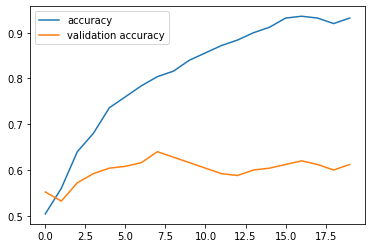

In [12]:
epochs = 20
batch_size = 25

r_DP = safeModel.fit(Xt_member, 
              yt_member, 
              validation_data=(Xt_nonmember, yt_nonmember),
              epochs=epochs, 
              batch_size=batch_size
)  


plt.plot(r_DP.history['accuracy'], label='accuracy')
plt.plot(r_DP.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show() 


In [13]:
theType= type(safeModel.optimizer)
print(f'optimiser is type {theType}')

dpused,reason = safeModel.check_DP_used(safeModel.optimizer)
print(f' It is {dpused} that the model will be DP because {reason}')

optimiser is type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
 It is True that the model will be DP because  value of optimizer._was_dp_gradients_called is True so DP variant of optimizer has been run


## compute privacy

In [14]:
print(f'dataset has {Xt.shape[0]} entries so batch size is {100*safeModel.batch_size/Xt.shape[0]}%')
privacy = compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=Xt.shape[0],
                                              batch_size=safeModel.batch_size,
                                              noise_multiplier=safeModel.noise_multiplier,
                                              epochs=25,#epochs,
                                              delta=1e-5)
print(f'with these settings privacy = {privacy}')

dataset has 500 entries so batch size is 5.0%
DP-SGD with sampling rate = 5% and noise_multiplier = 0.5 iterated over 500 steps satisfies differential privacy with eps = 43.9 and delta = 1e-05.
The optimal RDP order is 1.5.
with these settings privacy = (43.85228589564216, 1.5)


In [15]:
safeModel.save('safekeras.sav')

2022-05-20 10:47:43.195910: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: safekeras.sav/assets


In [16]:
safeModel.preliminary_check()

Model parameters are within recommended ranges.



('Model parameters are within recommended ranges.\n', False)

In [17]:
for key,value in safeModel.__dict__.items():
     print (f'thing associated with key {key} has type {type(value)}')

thing associated with key _self_setattr_tracking has type <class 'bool'>
thing associated with key _obj_reference_counts_dict has type <class 'keras.utils.object_identity.ObjectIdentityDictionary'>
thing associated with key inputs has type <class 'list'>
thing associated with key outputs has type <class 'list'>
thing associated with key l2_norm_clip has type <class 'float'>
thing associated with key noise_multiplier has type <class 'float'>
thing associated with key min_epsilon has type <class 'int'>
thing associated with key delta has type <class 'float'>
thing associated with key batch_size has type <class 'int'>
thing associated with key learning_rate has type <class 'float'>
thing associated with key _is_model_for_instrumentation has type <class 'bool'>
thing associated with key _instrumented_keras_api has type <class 'bool'>
thing associated with key _instrumented_keras_layer_class has type <class 'bool'>
thing associated with key _instrumented_keras_model_class has type <class 'b

In [18]:
all_keys = []
unusuals =[]
tuples =[]
deleted_keys = []

print("===============================================================================================")
print("Tuples")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == tuple):
        print (f'thing associated with key {key} has type {type(value)}')
        tuples.append(key)

print("===============================================================================================")
print("Bools")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == bool):
        print (f'thing associated with key {key} has type {type(value)}')

print("===============================================================================================")
print("Lists")
print("===============================================================================================")        
for key,value in safeModel.__dict__.items():
    if(type(value) == list):
        print (f'thing associated with key {key} has type {type(value)}')

print("===============================================================================================")
print("Strings")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == str):
        print (f'thing associated with key {key} has type {type(value)}')

        
print("===============================================================================================")
print("Ints")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == int):
        print (f'thing associated with key {key} has type {type(value)}')

print("===============================================================================================")
print("Floats")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == float):
        print (f'thing associated with key {key} has type {type(value)}')
        
print("===============================================================================================")
print("Dicts")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == dict):
        print (f'thing associated with key {key} has type {type(value)}')

        
print("===============================================================================================")
print("Sets")
print("===============================================================================================")
for key,value in safeModel.__dict__.items():
    if(type(value) == set):
        print (f'thing associated with key {key} has type {type(value)}')

print("===============================================================================================")
print("Unusual Ones")
print("===============================================================================================")

        
for key,value in safeModel.__dict__.items():
    if((type(value) != int) and (type(value) != str) and 
       (type(value) != list) and (type(value) != bool) and 
       (type(value) != tuple) and (type(value) != float) and
       (type(value) != dict) and (type(value) != set)):
        print (f'thing associated with key {key} has type {type(value)}')
        unusuals.append(key)

Tuples
thing associated with key _saved_model_arg_spec has type <class 'tuple'>
Bools
thing associated with key _self_setattr_tracking has type <class 'bool'>
thing associated with key _is_model_for_instrumentation has type <class 'bool'>
thing associated with key _instrumented_keras_api has type <class 'bool'>
thing associated with key _instrumented_keras_layer_class has type <class 'bool'>
thing associated with key _instrumented_keras_model_class has type <class 'bool'>
thing associated with key _trainable has type <class 'bool'>
thing associated with key _stateful has type <class 'bool'>
thing associated with key built has type <class 'bool'>
thing associated with key _supports_masking has type <class 'bool'>
thing associated with key _autocast has type <class 'bool'>
thing associated with key _expects_training_arg has type <class 'bool'>
thing associated with key _expects_mask_arg has type <class 'bool'>
thing associated with key _dynamic has type <class 'bool'>
thing associated wi

In [19]:
#safeModel.request_release('safekeras.pkl') # TypeError: cannot pickle '_thread.RLock' object

#safeModel.request_release('safekeras.sav') # TypeError: cannot pickle '_thread.RLock' object

#safeModel.request_release('safekeras.tf')




safeModel.save('my_model')
safeModel.save_weights('weights.h5')

safeModel.request_release('safe.sav')

INFO:tensorflow:Assets written to: my_model/assets
INFO:tensorflow:Assets written to: safe.sav/assets


...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread._local' object
...<class 'TypeError'> error; cannot pickle '_thread.lock' object


INFO:tensorflow:Assets written to: ram://a675b9b8-ce15-4d1c-aa13-7fabe1c52b9b/assets


...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


INFO:tensorflow:Assets written to: ram://3d2b23f6-1069-4045-97e5-fabccadf778d/assets


...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7f3b169fc940>
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7f3b169fc940>
DP-SGD with sampling rate = 10% and noise_multiplier = 0.5 iterated over 200 steps satisfies differential privacy with eps = 50.3 and delta = 1e-05.
The optimal RDP order is 1.5.
optimiser is type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
Error: user has not called fit() method or has deleted saved values.Recommendation: Do not release. It is True that the model will be DP because  value of optimizer._was_dp_gradients_called is True so DP variant of optimizer has been runepsilon is not sufficient for Differential privacy: 50.301726361197794. You must modify one or more of batch_size, epochs, number of samples.
 value of optimizer._was_dp_gr

In [20]:


safeModel.request_release('safekeras.h5')

...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread._local' object
...<class 'TypeError'> error; cannot pickle '_thread.lock' object


INFO:tensorflow:Assets written to: ram://d29cefd3-a730-4bd1-8e09-61b28d11dd05/assets


...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


INFO:tensorflow:Assets written to: ram://179b89ec-15fc-4d5e-b383-6d0e89ca8e9e/assets


...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7f3b169fc940>
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7f3b169fc940>
DP-SGD with sampling rate = 10% and noise_multiplier = 0.5 iterated over 200 steps satisfies differential privacy with eps = 50.3 and delta = 1e-05.
The optimal RDP order is 1.5.
optimiser is type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
Error: user has not called fit() method or has deleted saved values.Recommendation: Do not release. It is True that the model will be DP because  value of optimizer._was_dp_gradients_called is True so DP variant of optimizer has been runepsilon is not sufficient for Differential privacy: 50.301726361197794. You must modify one or more of batch_size, epochs, number of samples.
 value of optimizer._was_dp_gr

In [21]:
importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel

optimizer=None
safeModel = Safe_KerasModel(inputs= input_data, outputs=output,name="safekeras-test")

loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, reduction=tf.losses.Reduction.NONE)


safeModel.compile(loss=loss)#optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 20
batch_size = 25

r_DP = safeModel.fit(Xt_member, 
              yt_member, 
              validation_data=(Xt_nonmember, yt_nonmember),
              epochs=epochs, 
              batch_size=batch_size
)  


args is a <class 'tuple'> = ()  kwargs is a <class 'dict'>= {'inputs': <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'input_1')>, 'outputs': <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_3')>, 'name': 'safekeras-test'}
inputs is in kwargs.keys
KerasTensor(type_spec=TensorSpec(shape=(None, 300), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model parameters are within recommended ranges.

Changed parameter optimizer = 'DPKerasSGDOptimizer'
Unknown optimizer <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'> - Changed parameter optimizer = 'DPKerasSGDOptimizer'
DP optimizer used = False
optimizer has been changed but fit() has not been rerun.
(250, 300)
DP-SGD with sampling rate = 10% and noise_multiplier = 0.5 iterated over 200 steps satisfies differential privacy with eps = 50.3 and delta = 1e-05.
The optimal RDP order is 1.5.
Curr

In [22]:
importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel


# create and fit using recommended params


print("***Test 1: researcher doesn't change recommended params")
optimizer=None
safeKerasModel1 = Safe_KerasModel(inputs=input_data, outputs=output,name="safekerasmodel1-test")
safeKerasModel1.compile(loss=loss)
safeKerasModel1.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel1.save("safe1.pkl")
safeKerasModel1.preliminary_check()
safeKerasModel1.request_release(filename="safe1.pkl")

***Test 1: researcher doesn't change recommended params
args is a <class 'tuple'> = ()  kwargs is a <class 'dict'>= {'inputs': <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'input_1')>, 'outputs': <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_3')>, 'name': 'safekerasmodel1-test'}
inputs is in kwargs.keys
KerasTensor(type_spec=TensorSpec(shape=(None, 300), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model parameters are within recommended ranges.

Changed parameter optimizer = 'DPKerasSGDOptimizer'
Unknown optimizer <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'> - Changed parameter optimizer = 'DPKerasSGDOptimizer'
DP optimizer used = False
optimizer has been changed but fit() has not been rerun.
(250, 300)
DP-SGD with sampling rate = 10% and noise_multiplier = 0.5 iterated over 200 steps satisfies differential privacy with ep

...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread._local' object
...<class 'TypeError'> error; cannot pickle '_thread.lock' object


INFO:tensorflow:Assets written to: ram://0dd5efea-8333-44c5-821b-856ad6bffea5/assets


...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


INFO:tensorflow:Assets written to: ram://94f13272-4623-4105-8c6e-6b05827cff6f/assets


...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7f3b1661df40>
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7f3b1661df40>
DP-SGD with sampling rate = 10% and noise_multiplier = 0.5 iterated over 200 steps satisfies differential privacy with eps = 50.3 and delta = 1e-05.
The optimal RDP order is 1.5.
optimiser is type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
Error: user has not called fit() method or has deleted saved values.Recommendation: Do not release. It is True that the model will be DP because  value of optimizer._was_dp_gradients_called is True so DP variant of optimizer has been runepsilon is not sufficient for Differential privacy: 50.301726361197794. You must modify one or more of batch_size, epochs, number of samples.
 value of optimizer._was_dp_gr

In [23]:
importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel

# change model params to recommended values
print("\n***Test 2: researcher changes params safely")
safeKerasModel2 = Safe_KerasModel(inputs= input_data, outputs=output,name="safekerasmodel2-test", l2_norm_clip = 1.1, noise_multiplier=0.6)
safeKerasModel2.optimizer=tensorflow_privacy.DPKerasAdamOptimizer
safeKerasModel2.compile(loss=loss)
safeKerasModel2.l2_norm_clip = 1.1
safeKerasModel2.noise_multiplier = 0.6
safeKerasModel2.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)

safeKerasModel2.save("safe2.hd5")
safeKerasModel2.preliminary_check()
safeKerasModel2.request_release(filename="safe2.hd5")


***Test 2: researcher changes params safely
args is a <class 'tuple'> = ()  kwargs is a <class 'dict'>= {'inputs': <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'input_1')>, 'outputs': <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_3')>, 'name': 'safekerasmodel2-test', 'l2_norm_clip': 1.1, 'noise_multiplier': 0.6}
inputs is in kwargs.keys
KerasTensor(type_spec=TensorSpec(shape=(None, 300), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model parameters are within recommended ranges.

Unknown optimizer <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'> - Changed parameter optimizer = 'DPKerasSGDOptimizer'
DP optimizer used = False
optimizer has been changed but fit() has not been rerun.
(250, 300)
DP-SGD with sampling rate = 10% and noise_multiplier = 0.6 iterated over 200 steps satisfies differential privacy with eps = 32.9 and delt

...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread._local' object
...<class 'TypeError'> error; cannot pickle '_thread.lock' object


INFO:tensorflow:Assets written to: ram://3be24347-d23f-45c9-8e8b-a6fb8d090cd8/assets


...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


INFO:tensorflow:Assets written to: ram://373f4351-970f-4dfa-8815-d47a18733f74/assets


...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7f3b165d0640>
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7f3b165d0640>
DP-SGD with sampling rate = 10% and noise_multiplier = 0.6 iterated over 200 steps satisfies differential privacy with eps = 32.9 and delta = 1e-05.
The optimal RDP order is 1.75.
optimiser is type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
Error: user has not called fit() method or has deleted saved values.Recommendation: Do not release. It is True that the model will be DP because  value of optimizer._was_dp_gradients_called is True so DP variant of optimizer has been runepsilon is not sufficient for Differential privacy: 32.860767694468635. You must modify one or more of batch_size, epochs, number of samples.
 value of optimizer._was_dp_g

In [24]:
importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel

# change one model params in an unsafe way
print("\n***Test 3: researcher changes string params unsafely")
safeKerasModel3 = Safe_KerasModel(inputs= input_data, outputs=output,name="safekerasmodel3-test", l2_norm_clip = 0.8)
safeKerasModel3.compile(loss=loss)
#safeKerasModel3.optimizer="Adam"
safeKerasModel3.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel3.save("unsafe3.hd5")
safeKerasModel3.preliminary_check()
safeKerasModel3.request_release(filename="unsafe3.hd5")


***Test 3: researcher changes string params unsafely
args is a <class 'tuple'> = ()  kwargs is a <class 'dict'>= {'inputs': <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'input_1')>, 'outputs': <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_3')>, 'name': 'safekerasmodel3-test', 'l2_norm_clip': 0.8}
inputs is in kwargs.keys
KerasTensor(type_spec=TensorSpec(shape=(None, 300), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
- parameter l2_norm_clip = 0.8 identified as less than the recommended min value of 1.0.
Changed parameter l2_norm_clip = 1.0.

Changed parameter optimizer = 'DPKerasSGDOptimizer'
Unknown optimizer <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'> - Changed parameter optimizer = 'DPKerasSGDOptimizer'
DP optimizer used = False
optimizer has been changed but fit() has not been rerun.
(250, 300)
DP-SGD with sampling ra

...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread._local' object
...<class 'TypeError'> error; cannot pickle '_thread.lock' object


INFO:tensorflow:Assets written to: ram://1a421f7a-29f9-4f04-a730-6fe78cdf56c6/assets


...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


INFO:tensorflow:Assets written to: ram://2a677b32-54ce-4cfe-9f1c-301520c886c0/assets


...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7f3aff2af2b0>
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7f3aff2af2b0>
DP-SGD with sampling rate = 10% and noise_multiplier = 0.5 iterated over 200 steps satisfies differential privacy with eps = 50.3 and delta = 1e-05.
The optimal RDP order is 1.5.
optimiser is type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
Error: user has not called fit() method or has deleted saved values.Recommendation: Do not release. It is True that the model will be DP because  value of optimizer._was_dp_gradients_called is True so DP variant of optimizer has been runepsilon is not sufficient for Differential privacy: 50.301726361197794. You must modify one or more of batch_size, epochs, number of samples.
 value of optimizer._was_dp_gr

In [25]:
# change another model params in an  unsafe way
importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel

print("\n***Test 3: researcher changes string params unsafely")
safeKerasModel4 = Safe_KerasModel(inputs= input_data, outputs=output,name="safekerasmodel3-test", delta=-1)
safeKerasModel4.compile(loss=loss)
#safeKerasModel3.optimizer="Adam"
safeKerasModel4.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel4.save("unsafe3.hd5")
safeKerasModel4.preliminary_check()
safeKerasModel4.request_release(filename="unsafe4.hd5")


***Test 3: researcher changes string params unsafely
args is a <class 'tuple'> = ()  kwargs is a <class 'dict'>= {'inputs': <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'input_1')>, 'outputs': <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_3')>, 'name': 'safekerasmodel3-test', 'delta': -1}
inputs is in kwargs.keys
KerasTensor(type_spec=TensorSpec(shape=(None, 300), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
- parameter delta = -1 identified as less than the recommended min value of 1e-05.
Changed parameter delta = 1e-05.

Changed parameter optimizer = 'DPKerasSGDOptimizer'
Unknown optimizer <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'> - Changed parameter optimizer = 'DPKerasSGDOptimizer'
DP optimizer used = False
optimizer has been changed but fit() has not been rerun.
(250, 300)
DP-SGD with sampling rate = 10% and noise_

...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread._local' object
...<class 'TypeError'> error; cannot pickle '_thread.lock' object


INFO:tensorflow:Assets written to: ram://5258e407-d409-43ca-9201-3fa13eac3528/assets


...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


INFO:tensorflow:Assets written to: ram://4de989da-cc80-4f7e-a4af-741b51e8599d/assets


...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7f3afdf849d0>
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7f3afdf849d0>
DP-SGD with sampling rate = 10% and noise_multiplier = 0.5 iterated over 200 steps satisfies differential privacy with eps = 50.3 and delta = 1e-05.
The optimal RDP order is 1.5.
optimiser is type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
Error: user has not called fit() method or has deleted saved values.Recommendation: Do not release. It is True that the model will be DP because  value of optimizer._was_dp_gradients_called is True so DP variant of optimizer has been runepsilon is not sufficient for Differential privacy: 50.301726361197794. You must modify one or more of batch_size, epochs, number of samples.
 value of optimizer._was_dp_gr

In [26]:
# change another model params in an  unsafe way
print("\n***Test 5: researcher changes string and numeric params unsafely")

importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel


safeKerasModel4 = Safe_KerasModel(inputs= input_data, outputs=output,name="safekerasmodel3-test", l2_norm_clip=0.9, noise_multipier=0.4, min_epsilon=9,delta=-1)
safeKerasModel4.compile(loss=loss)
#safeKerasModel3.optimizer="Adam"
safeKerasModel4.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel4.save("unsafe3.hd5")
safeKerasModel4.preliminary_check()
safeKerasModel4.request_release(filename="unsafe4.hd5")


***Test 5: researcher changes string and numeric params unsafely
args is a <class 'tuple'> = ()  kwargs is a <class 'dict'>= {'inputs': <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'input_1')>, 'outputs': <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_3')>, 'name': 'safekerasmodel3-test', 'l2_norm_clip': 0.9, 'noise_multipier': 0.4, 'min_epsilon': 9, 'delta': -1}
inputs is in kwargs.keys
KerasTensor(type_spec=TensorSpec(shape=(None, 300), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
- parameter l2_norm_clip = 0.9 identified as less than the recommended min value of 1.0.
Changed parameter l2_norm_clip = 1.0.
- parameter min_epsilon = 9 identified as less than the recommended min value of 10.
Changed parameter min_epsilon = 10.
- parameter delta = -1 identified as less than the recommended min value of 1e-05.
Changed parameter delta = 1e-05.

Changed parameter optimizer = 'DPKerasSGDOptimizer'
Unkno

...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread._local' object
...<class 'TypeError'> error; cannot pickle '_thread.lock' object


INFO:tensorflow:Assets written to: ram://35dbdde2-2c80-45aa-a42b-9ee2e84fe568/assets


...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


INFO:tensorflow:Assets written to: ram://841d5250-734a-47d0-9470-a3cf9108e60d/assets


...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7f3aff49cee0>
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7f3aff49cee0>
DP-SGD with sampling rate = 10% and noise_multiplier = 0.5 iterated over 200 steps satisfies differential privacy with eps = 50.3 and delta = 1e-05.
The optimal RDP order is 1.5.
optimiser is type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
Error: user has not called fit() method or has deleted saved values.Recommendation: Do not release. It is True that the model will be DP because  value of optimizer._was_dp_gradients_called is True so DP variant of optimizer has been runepsilon is not sufficient for Differential privacy: 50.301726361197794. You must modify one or more of batch_size, epochs, number of samples.
 value of optimizer._was_dp_gr

In [27]:
importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel

# change another model params in an  unsafe way but tells preliminary_check() not to overwrite params
print("\n***Test 6: researcher changes string and numeric params unsafely")
safeKerasModel6 = Safe_KerasModel(inputs= input_data, outputs=output,name="safekerasmodel6-test", optimizer="wobble")
safeKerasModel6.compile(loss=loss)
safeKerasModel6.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel6.save("unsafe6.hd5")

safeKerasModel6.preliminary_check(apply_constraints=False)
safeKerasModel6.request_release(filename="unsafe6.hd5")


***Test 6: researcher changes string and numeric params unsafely
args is a <class 'tuple'> = ()  kwargs is a <class 'dict'>= {'inputs': <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'input_1')>, 'outputs': <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_3')>, 'name': 'safekerasmodel6-test', 'optimizer': 'wobble'}
inputs is in kwargs.keys
KerasTensor(type_spec=TensorSpec(shape=(None, 300), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model parameters are within recommended ranges.

Unknown optimizer wobble - Changed parameter optimizer = 'DPKerasSGDOptimizer'
DP optimizer used = False
optimizer has been changed but fit() has not been rerun.
(250, 300)
DP-SGD with sampling rate = 10% and noise_multiplier = 0.5 iterated over 200 steps satisfies differential privacy with eps = 50.3 and delta = 1e-05.
The optimal RDP order is 1.5.
Current epsilon is 50.301726361197794
The requirements for DP are not met,

...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread._local' object
...<class 'TypeError'> error; cannot pickle '_thread.lock' object


INFO:tensorflow:Assets written to: ram://0a5e60ac-4e7c-4d72-9a41-602dae4856ec/assets


...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


INFO:tensorflow:Assets written to: ram://90d10c78-d3fd-4aab-accd-35ddf6457d9a/assets


...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7f3afbe14ac0>
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7f3afbe14ac0>
DP-SGD with sampling rate = 10% and noise_multiplier = 0.5 iterated over 200 steps satisfies differential privacy with eps = 50.3 and delta = 1e-05.
The optimal RDP order is 1.5.
optimiser is type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
Error: user has not called fit() method or has deleted saved values.Recommendation: Do not release. It is True that the model will be DP because  value of optimizer._was_dp_gradients_called is True so DP variant of optimizer has been runepsilon is not sufficient for Differential privacy: 50.301726361197794. You must modify one or more of batch_size, epochs, number of samples.
 value of optimizer._was_dp_gr

In [28]:
importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel

# change another model params in an  unsafe way but tells preliminary_check() not to overwrite params
print("\n***Test 7: researcher changes string and numeric params unsafely")
safeKerasModel6 = Safe_KerasModel(inputs= input_data, outputs=output,name="safekerasmodel6-test", optimizer="Adam")
safeKerasModel6.compile(loss=loss)
safeKerasModel6.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel6.save("unsafe7.hd5")

safeKerasModel6.preliminary_check(apply_constraints=False)
safeKerasModel6.request_release(filename="unsafe7.hd5")


***Test 7: researcher changes string and numeric params unsafely
args is a <class 'tuple'> = ()  kwargs is a <class 'dict'>= {'inputs': <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'input_1')>, 'outputs': <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_3')>, 'name': 'safekerasmodel6-test', 'optimizer': 'Adam'}
inputs is in kwargs.keys
KerasTensor(type_spec=TensorSpec(shape=(None, 300), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model parameters are within recommended ranges.

Changed parameter optimizer = 'DPKerasAdamOptimizer'
DP optimizer used = False
optimizer has been changed but fit() has not been rerun.
(250, 300)
DP-SGD with sampling rate = 10% and noise_multiplier = 0.5 iterated over 200 steps satisfies differential privacy with eps = 50.3 and delta = 1e-05.
The optimal RDP order is 1.5.
Current epsilon is 50.301726361197794
The requirements for DP are not met, current epsilon is: 50.3017

...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread._local' object
...<class 'TypeError'> error; cannot pickle '_thread.lock' object


INFO:tensorflow:Assets written to: ram://f1b61f81-0d0b-48c5-b172-e927a1662328/assets


...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


INFO:tensorflow:Assets written to: ram://d4648750-cc69-48ab-87a2-ff536c05cf0c/assets


...<class 'ValueError'> error; Unknown optimizer: DPOptimizerClass. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object
...<class 'TypeError'> error; cannot pickle '_thread.RLock' object


<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7f3afbd52790>
<tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7f3afbd52790>
DP-SGD with sampling rate = 10% and noise_multiplier = 0.5 iterated over 200 steps satisfies differential privacy with eps = 50.3 and delta = 1e-05.
The optimal RDP order is 1.5.
optimiser is type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
Error: user has not called fit() method or has deleted saved values.Recommendation: Do not release. It is True that the model will be DP because  value of optimizer._was_dp_gradients_called is True so DP variant of optimizer has been runepsilon is not sufficient for Differential privacy: 50.301726361197794. You must modify one or more of batch_size, epochs, number of samples.
 value of optimizer._was_dp_gr